In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input

In [2]:
def iou(bbx_1, bbx_2):
    x1 = max(bbx_1[0], bbx_2[0])
    y1 = max(bbx_1[1], bbx_2[1])
    x2 = min(bbx_1[2], bbx_2[2])
    y2 = min(bbx_1[3], bbx_2[3])
    intersection = max(x2-x1, 0)*max(y2-y1, 0)
    bbx_1_area = np.abs((bbx_1[2] - bbx_1[0])*(bbx_1[3] - bbx_1[1]))
    bbx_2_area = np.abs((bbx_2[2] - bbx_2[0])*(bbx_2[3] - bbx_2[1]))
    return intersection/(bbx_1_area + bbx_2_area - intersection + 1e-6)

In [3]:
def nms(bboxes, iou_threshold=0.5):
    bboxes = sorted(bboxes, key=lambda x: x[0], reverse=True)
    final_bboxes = []
    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [
            box
            for box in bboxes
            if iou(
                chosen_box[2:],
                box[2:],
            )
            < iou_threshold
            or box[1] != chosen_box[1]
        ]
        final_bboxes.append(chosen_box)
    
    final_bboxes = sorted(
            final_bboxes,
            key=lambda x: (x[4]-x[2])*(x[5] - x[3]),
            reverse=True
    )
    
    return final_bboxes

In [4]:
def predict(image, threshold=0.85):
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    prediction = model.predict(image)
    output = decode_predictions(prediction, top=1)[0]
    if output[0][2] > threshold:
        return [output[0][1], output[0][2]]
    else:
        return None

In [5]:
def sliding_window(image, upscale, threshold=0.5, h=224, w=224, step=30):
    orig = image
    predictions = []
    for y in range(0, image.shape[0] - h, step):
        for x in range(0, image.shape[1] -w, step):
            img = image[y: y+h, x: x+w]
            prediction = predict(img)
            if prediction is not None:
                prediction_class, confidence = prediction
                predictions.append([confidence, prediction_class, x*upscale, y*upscale, (x+w)*upscale, (y+h)*upscale])
    return predictions

In [6]:
def image_pyramid(image, down_scale):
    i = 0
    upscale = 1
    bboxes = []
    while True:
        if i >= 2:
            h = int(image.shape[0]/down_scale)
            w = int(image.shape[1]/down_scale)
            image = cv2.resize(image, (w, h))
            upscale *= down_scale
        if image.shape[1] < 224 or image.shape[0] < 224:
            break
        predictions = sliding_window(image, upscale)
        i += 1
        bboxes.extend(predictions)
    final_bbx = nms(bboxes)
    final_final = []
    while final_bbx:
        chosen_box = final_bbx.pop(0)
        final_bbx = [
            bbx 
            for bbx in final_bbx 
            if bbx[2] > chosen_box[4]
            and bbx[3] > chosen_box[5]
        ]
        final_final.append(chosen_box)
    return final_final

In [7]:
def main(image_path):
    img = cv2.imread(image_path)
    H, W, _ = img.shape
    w = 600
    h = int((H/W)*w)
    img_ = cv2.resize(img, (w, h))
    outputs = image_pyramid(img_, 1.5)
    for output in outputs:
        new_image = img.copy()
        class_prediction = output[1]
        x1 = int((output[2]/w)*W)
        y1 = int((output[3]/h)*H)
        x2 = int((output[4]/w)*W)
        y2 = int((output[5]/h)*H)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
        cv2.putText(
            img, 
            f'{class_prediction.upper()}', 
            (x1 + 10 , y2+5), 
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3
        )

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
model = MobileNetV2(weights='imagenet', include_top=True)

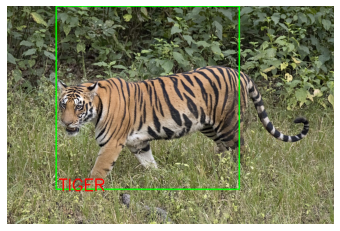

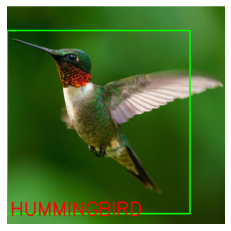

In [9]:
image_paths = ['tiger_2.jpg', 'bird2.jpg']
for image_path in image_paths:
    main(image_path)